In [60]:
# =====================================
# IMPORTY
# =====================================
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss, roc_curve, precision_recall_curve
import optuna
from optuna import visualization as vis
from sklearn.linear_model import LogisticRegression
from IPython.display import display
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:

# =====================================
# PARAMETRY
# =====================================
DATA_PATH = "zbiór_8.csv"
RANDOM_SEED = 3
CORR_THRESHOLD = 0.8
N_BINS = 8
EPS = 1e-6
IV_THRESHOLD = 0.1



In [3]:

# =====================================
# WCZYTANIE + SPLIT
# =====================================
df = pd.read_csv(DATA_PATH)

df_train, df_tmp = train_test_split(df, train_size=0.7, stratify=df["default"], random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_tmp, test_size=0.5, stratify=df_tmp["default"], random_state=RANDOM_SEED)

X_train, y_train = df_train.drop(columns="default"), df_train["default"]
X_val, y_val = df_val.drop(columns="default"), df_val["default"]
X_test, y_test = df_test.drop(columns="default"), df_test["default"]

In [4]:
# -------------------------------------
# WRAPPERY DO ZACHOWANIA NAZW KOLUMN
# -------------------------------------
class ColumnNamePreservingPipeline(Pipeline):
    def transform(self, X):
        X_transformed = super().transform(X)
        if isinstance(X_transformed, np.ndarray):
            if hasattr(self.steps[-1][1], "get_feature_names_out"):
                cols = self.steps[-1][1].get_feature_names_out(X.columns)
            else:
                cols = X.columns
            X_transformed = pd.DataFrame(X_transformed, columns=cols, index=X.index)
        return X_transformed

    def fit_transform(self, X, y=None, **fit_params):
        Xt = super().fit_transform(X, y, **fit_params)
        if isinstance(Xt, np.ndarray):
            if hasattr(self.steps[-1][1], "get_feature_names_out"):
                cols = self.steps[-1][1].get_feature_names_out(X.columns)
            else:
                cols = X.columns
            Xt = pd.DataFrame(Xt, columns=cols, index=X.index)
        return Xt



class ColumnNamePreservingCT(ColumnTransformer):
    def transform(self, X):
        X_transformed = super().transform(X)
        cols = []
        for name, trans, cols_in in self.transformers_:
            if trans == 'drop':
                continue
            if hasattr(trans, 'get_feature_names_out'):
                cols.extend(trans.get_feature_names_out(cols_in))
            else:
                cols.extend(cols_in)
        return pd.DataFrame(X_transformed, columns=cols, index=X.index)


In [5]:
# =====================================
# TRANSFORMATORY
# =====================================

class UnimportantDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        zero_percentage = (X[:] == 0).sum() / len(X)

        cols_many_zeros = zero_percentage[zero_percentage > 0.5].index.tolist()

        cols_many_zeros = [col for col in cols_many_zeros 
                        if not col.startswith('wsk') 
                        and col != 'pkdKod' ]
        manual_cols=['szczegolnaFormaPrawna_Symbol', 'RP_przeplywy_operacyjne', 'RP_amortyzacja', 'wsk_pokrycie_zob_kr_gotowkowe_2', 'wsk_zadluzenia_gotowki_2', 'wsk_akt_generowania_got_2', 'wsk_pokrycie_wyd_fin_gotowkowe_2', 'wsk_zysk_CF_operacyjny', 'schemat_wsk_bilans']
        
        cols_to_drop = cols_many_zeros + manual_cols
        self.keep_ = [c for c in X.columns if c not in cols_to_drop]
        
        return self

    def transform(self, X):
        return X[self.keep_].copy()
    
    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)
    
class CategoricalRuleBasedImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_impute):
        
        self.cols_to_impute = cols_to_impute
        self.modes_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        
        for col in self.cols_to_impute:
            if X[col].notna().sum() > 0:
                self.modes_[col] = X[col].mode()[0]
            else:
                self.modes_[col] = None  # Na wypadek gdyby cała kolumna była NaN
        return self

    def transform(self, X):
        X = X.copy()
        for col, mode_val in self.modes_.items():
            if mode_val is not None:
                X[col] = X[col].replace(0, np.nan)
                X[col] = X[col].fillna(mode_val)
                
        return X
    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)
    
        
        

class NumericalRuleBasedImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_impute):
        self.cols_to_impute = cols_to_impute

    def fit(self, X, y=None):
        X = X.copy()


        self.medians_ = {}
        for col in self.cols_to_impute:
            median_val = X.loc[X[col] != 0, col].median()
            self.medians_[col] = median_val

 
        wsk_cols = [c for c in X.columns if c.startswith('wsk')]
        self.drop_ = []
        self.fill_ = []
        for col in wsk_cols:
            pct_missing = ((X[col] == 0) | X[col].isna() | (X[col] == np.inf) | (X[col] == -np.inf)).mean() * 100
            if pct_missing > 20:
                self.drop_.append(col)  
            else:
                self.fill_.append(col)  

        self.keep_ = [c for c in X.columns if c not in self.drop_]
        return self

    def transform(self, X):
        X = X.copy()

        for col, median_val in self.medians_.items():
            if col in X.columns:
                X[col] = X[col].replace([0, np.inf, -np.inf], np.nan)
                X[col] = X[col].fillna(median_val)

        for col in self.fill_:
            if col in X.columns:
                median_val = X[col].median()
                X[col] = X[col].replace([0, np.inf, -np.inf], np.nan)
                X[col] = X[col].fillna(median_val)

        X = X.drop(columns=self.drop_, errors='ignore')

        return X

    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)
    
    


In [6]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # wykrycie mocno skośnych kolumn (>2)
        skew_values = X.skew()
        self.cols_ = skew_values[skew_values > 2].index.tolist()
        # zachowanie kolejności kolumn
        self.keep_ = X.columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols_:
            min_val = X[col].min()
            X[col] = X[col] + abs(min_val) + 1
            X[col] = np.log(X[col])
        return X

    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)


class OutlierCapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.no_cap_cols = []
        self.moderate_iqr_cols = []
        self.percentile_cols = []

        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_1_5 = Q1 - 1.5 * IQR
            upper_1_5 = Q3 + 1.5 * IQR
            
            below = (X[col] < lower_1_5).sum()
            above = (X[col] > upper_1_5).sum()
            perc_outliers = (below + above) / len(X[col])
            
            if perc_outliers == 0:
                self.no_cap_cols.append(col)
            elif perc_outliers <= 0.1:
                self.moderate_iqr_cols.append(col)
            else:
                self.percentile_cols.append(col)
        return self

    def transform(self, X):
        for col in self.moderate_iqr_cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            X[col] = X[col].clip(lower=lower, upper=upper)

        for col in self.percentile_cols:
            lower = X[col].quantile(0.01)
            upper = X[col].quantile(0.99)
            X[col] = X[col].clip(lower=lower, upper=upper)
        return X

    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)



class HighCorrelationDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold

    def fit(self, X, y=None):
        Xc = X.copy()
        Xc = Xc[Xc.columns.sort_values()]  
        while True:
            corr = Xc.corr().abs()
            upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

            # znajdź wszystkie pary z korelacją > threshold
            to_drop_pairs = [
                (col1, col2)
                for col1 in upper.columns
                for col2 in upper.index
                if pd.notnull(upper.loc[col1, col2]) and upper.loc[col1, col2] > self.threshold
            ]

            if not to_drop_pairs:
                break

            # zliczamy częstotliwość występowania kolumn w parach do usunięcia
            freq = {}
            for col1, col2 in to_drop_pairs:
                freq[col1] = freq.get(col1, 0) + 1
                freq[col2] = freq.get(col2, 0) + 1

            # wybieramy kolumnę, która występuje najczęściej
            max_freq = max(freq.values())
            max_cols = [col for col, f in freq.items() if f == max_freq]
            col_to_drop = sorted(max_cols)[-1]  # ostatnia alfabetycznie

            Xc = Xc.drop(columns=[col_to_drop])

        self.keep_ = Xc.columns.tolist()
        return self

    def transform(self, X):
        return X[self.keep_].copy()

    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)
    
    


In [7]:
class Binner(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=5):
        self.n_bins = n_bins

    def fit(self, X, y=None):
        self.bin_edges_ = {}
        self.keep_ = []
        
        for col in X.columns:
            s = X[col].replace([np.inf, -np.inf], np.nan).dropna()

            if s.nunique() >= 2:  # minimalnie 2 unikalne wartości potrzebne do podziału
                for q in range(self.n_bins, 1, -1):  # próbuj mniejszą liczbę binów, jeśli qcut się nie uda
                    try:
                        _, bins = pd.qcut(s, q=q, retbins=True, duplicates='drop')
                        # Rozszerz biny, żeby objęły cały zakres (i ewentualne outliery)
                        bins[0] = -np.inf
                        bins[-1] = np.inf
                        self.bin_edges_[col] = bins
                        break
                    except Exception:
                        continue
            # zapamiętaj kolumny, żeby zachować kolejność feature’ów
            self.keep_.append(col)

        return self

    def transform(self, X):
        X = X.copy()
        for col, bins in self.bin_edges_.items():
            # zamień infy na nan (będą obsłużone przez cut)
            X[col] = X[col].replace([np.inf, -np.inf], np.nan)
            X[col] = pd.cut(X[col], bins=bins, include_lowest=True)
        return X

    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)


import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import warnings

EPS = 1e-10

class WOETransformer(BaseEstimator, TransformerMixin):
    """
    Transformer obliczający Weight of Evidence (WOE)
    - Obsługuje rzadkie kategorie i nowe kategorie w transform().
    - Rzadkie kategorie (liczba < min_count) są grupowane jako '__OTHER__'.
    """

    def __init__(self, min_count=40, random_state=None, warn_on_unknown=True):
        """
        Parametry:
        ----------
        min_count : int
            Minimalna liczba wystąpień kategorii, poniżej której trafia do '__OTHER__'.
        random_state : int | None
            Ziarno losowe (niepotrzebne, ale można zachować dla spójności).
        warn_on_unknown : bool
            Czy ostrzegać o nowych kategoriach przy transformacji.
        """
        self.min_count = min_count
        self.random_state = random_state
        self.warn_on_unknown = warn_on_unknown
        if random_state is not None:
            np.random.seed(random_state)

    def fit(self, X, y):
        self.maps_ = {}
        self.keep_ = X.columns.tolist()
        tmp = pd.concat([X, y], axis=1)

        for col in X.columns:
            col_series = tmp[col].astype(object)

            # Zliczanie kategorii i oznaczenie rzadkich jako '__OTHER__'
            counts = col_series.value_counts()
            col_mapped = col_series.where(col_series.map(counts) >= self.min_count, '__OTHER__')

            # Grupowanie po zmodyfikowanych kategoriach
            grp = tmp.assign(**{col: col_mapped}).groupby(col)[y.name].agg(['sum', 'count'])
            grp['good'] = grp['count'] - grp['sum']
            grp['bad_dist'] = grp['sum'] / grp['sum'].sum()
            grp['good_dist'] = grp['good'] / grp['good'].sum()
            grp['woe'] = np.log((grp['good_dist'] + EPS) / (grp['bad_dist'] + EPS))

            mapping = grp['woe'].to_dict()

            # upewniamy się, że '__OTHER__' istnieje w mapowaniu
            if '__OTHER__' not in mapping:
                mapping['__OTHER__'] = 0.0  # lub inna logika np. średnia WOE

            self.maps_[col] = mapping

        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            mapping = self.maps_[col]

            # mapowanie, brakujące wartości trafiają do '__OTHER__'
            mapped = X[col].astype(object).map(lambda x: mapping.get(x, mapping['__OTHER__']))

            # opcjonalne ostrzeżenie
            unknown_mask = ~X[col].isin(mapping.keys())
            if unknown_mask.any() and self.warn_on_unknown:
                unknown_values = X.loc[unknown_mask, col].unique()
                warnings.warn(
                    f"WOETransformer: kolumna '{col}' zawiera nieznane kategorie: {unknown_values}. "
                    "Zastąpiono je '__OTHER__'."
                )

            X[col] = mapped

        return X

    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)


class IVSelectorDropper(BaseEstimator, TransformerMixin):
    """
    Selekcja cech na podstawie wartości IV (Information Value).
    Zakłada, że kolumny zawierają już wartości WOE.
    Zwraca zawsze pandas.DataFrame z zachowaniem kolumn.
    """

    def __init__(self, threshold=IV_THRESHOLD):
        self.threshold = threshold

    def fit(self, X, y):
        # Konwersja do DataFrame/Series dla bezpieczeństwa
        X = pd.DataFrame(X)
        y = pd.Series(y)

        n_event = np.sum(y == 1)
        n_non = np.sum(y == 0)

        ivs = {}
        for col in X.columns:
            iv_sum = 0.0
            vals = np.unique(X[col])
            for val in vals:
                # udział event i non-event
                p_event = np.sum((X[col] == val) & (y == 1)) / n_event
                p_non_event = np.sum((X[col] == val) & (y == 0)) / n_non
                woe_val = float(val)  # zakładamy, że val to WOE
                iv_sum += (p_non_event - p_event) * woe_val
            ivs[col] = iv_sum

        # Series z IV i lista kolumn do zachowania
        self.ivs_ = pd.Series(ivs).sort_values(ascending=False)
        self.keep_ = self.ivs_[self.ivs_ >= self.threshold].index.tolist()

        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        # wybór tylko kolumn z IV >= threshold
        X_selected = X[self.keep_]
        # upewniamy się, że wszystkie wartości numeryczne
        X_selected = X_selected.apply(pd.to_numeric, errors='coerce')
        return X_selected  # zawsze DataFrame

    def get_feature_names_out(self, input_features=None):
        return getattr(self, 'keep_', input_features)
    
    
class CorrDropper2(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.to_drop_ = []
        self.keep_ = []

    def fit(self, X, y=None):
        # liczymy korelacje tylko dla kolumn numerycznych
        corr_matrix = X.corr(numeric_only=True).abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
        # kolumny, które zachowujemy
        self.keep_ = [col for col in X.columns if col not in self.to_drop_]
        return self

    def transform(self, X):
        X_reduced = X.drop(columns=self.to_drop_, errors='ignore')
        
        return X_reduced

    def get_feature_names_out(self, input_features=None):
        # jeśli są zachowane kolumny, zwróć je
        if hasattr(self, 'keep_') and self.keep_:
            return self.keep_
        return input_features
    
class CorrelationChanger(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        corrs = X.apply(lambda col: np.corrcoef(col, y)[0, 1])
        self.neg_corr_cols_ = corrs[corrs < 0].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        # odwracamy tylko kolumny które faktycznie istnieją
        for col in self.neg_corr_cols_:
            if col in X.columns:
                X[col] = -X[col]
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features



In [8]:
# =====================================
# PIPELINE
# =====================================
cat_cols = ['formaWlasnosci_Symbol', 'pkdKod', 'schemat_wsk_rzis'] 
num_cols = [col for col in X_train.columns if col not in cat_cols]

num_pipeline = ColumnNamePreservingPipeline([
    ("drop_num", UnimportantDropper()),
    ("imp_num", NumericalRuleBasedImputer(cols_to_impute=[
            'Aktywa', 'Aktywa_trwale', 'Aktywa_obrotowe', 'Naleznosci_krotkoterminowe',
            'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Kapital_wlasny', 'Kapital_podstawowy',
            'Zysk_netto', 'Zobowiazania_rezerwy', 'Zobowiazania_krotkoterminowe',
            'przychody_sprzedazy', 'zysk_sprzedazy', 'pozostale_przychody_oper', 'koszty_operacyjne_pozostale',
            'zysk_operacyjny', 'koszty_finansowe', 'zysk_brutto', 'podatek_dochodowy'
])),
    ("log", LogTransformer()),
    ("cap", OutlierCapper()),
    ("corr", HighCorrelationDropper()),
    ("bin", Binner()),
    ("woe_num", WOETransformer()),
    ("IV_selector_num", IVSelectorDropper(threshold=IV_THRESHOLD)),
    ("cor_ch_num", CorrelationChanger()),
    ("corr2_num", CorrDropper2(threshold=CORR_THRESHOLD))
])

cat_pipeline = ColumnNamePreservingPipeline([
    ("drop_cat", UnimportantDropper()),
    ("imp_cat", CategoricalRuleBasedImputer(cols_to_impute=["formaWlasnosci_Symbol"])),
    ("woe_cat", WOETransformer()),
    ("IV_selector_cat", IVSelectorDropper(threshold=IV_THRESHOLD)),
    ("cor_ch_cat", CorrelationChanger()),
    ("corr2_cat", CorrDropper2(threshold=CORR_THRESHOLD))
])

preprocess = ColumnNamePreservingCT([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols) 
])

pipeline = ColumnNamePreservingPipeline([
    ("preprocess", preprocess)
])

pipeline

ColumnNamePreservingPipeline(steps=[('preprocess',
                                     ColumnNamePreservingCT(transformers=[('num',
                                                                           ColumnNamePreservingPipeline(steps=[('drop_num',
                                                                                                                UnimportantDropper()),
                                                                                                               ('imp_num',
                                                                                                                NumericalRuleBasedImputer(cols_to_impute=['Aktywa',
                                                                                                                                                          'Aktywa_trwale',
                                                                                                                                                          'Aktywa_obrotowe',
                                                                                                                                                          'Naleznosci_krotkoterminowe',
                                                                                                                                                          'Inwestycje_krotkoterminowe',
                                                                                                                                                          'Srodki_pieniezne',
                                                                                                                                                          'Kapital_wlas...
                                                                          ('cat',
                                                                           ColumnNamePreservingPipeline(steps=[('drop_cat',
                                                                                                                UnimportantDropper()),
                                                                                                               ('imp_cat',
                                                                                                                CategoricalRuleBasedImputer(cols_to_impute=['formaWlasnosci_Symbol'])),
                                                                                                               ('woe_cat',
                                                                                                                WOETransformer()),
                                                                                                               ('IV_selector_cat',
                                                                                                                IVSelectorDropper()),
                                                                                                               ('cor_ch_cat',
                                                                                                                CorrelationChanger()),
                                                                                                               ('corr2_cat',
                                                                                                                CorrDropper2())]),
                                                                           ['formaWlasnosci_Symbol',
                                                                            'pkdKod',
                                                                            'schemat_wsk_rzis'])]))])

In [9]:
# =====================================
# FIT + TRANSFORM
# =====================================
pipeline.fit(X_train, y_train)

X_train_t = pipeline.transform(X_train)
X_val_t = pipeline.transform(X_val)
X_test_t = pipeline.transform(X_test)



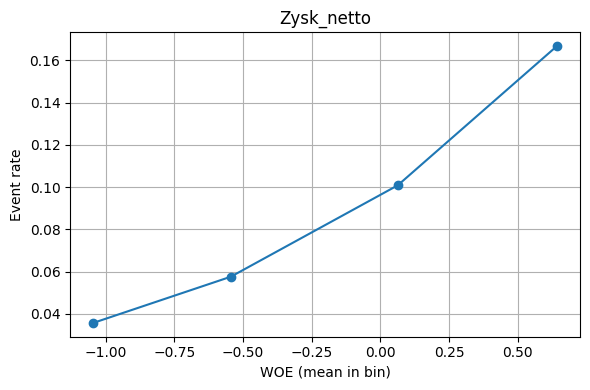

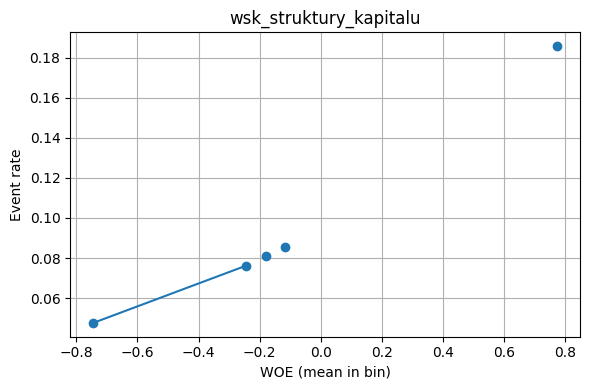

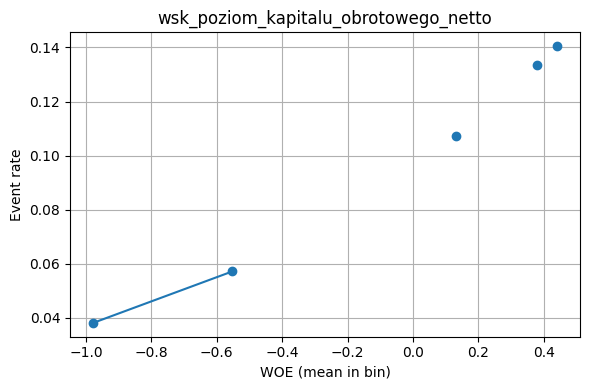

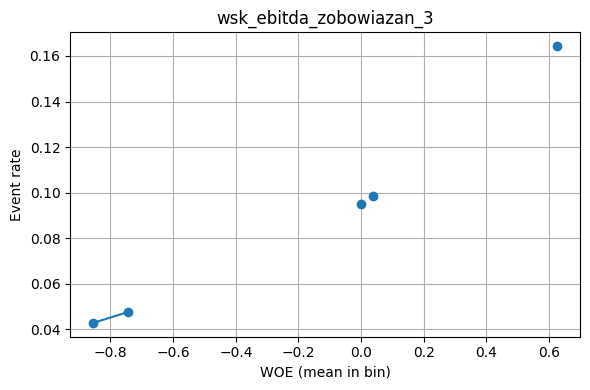

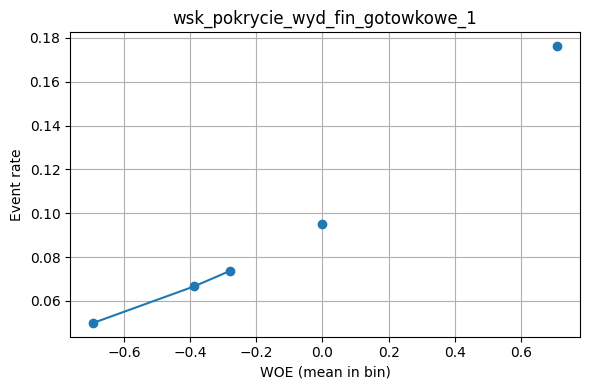

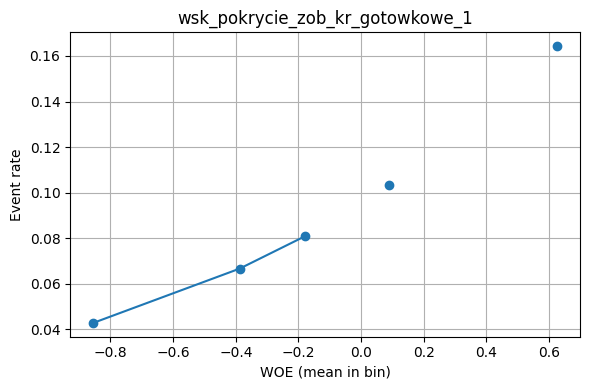

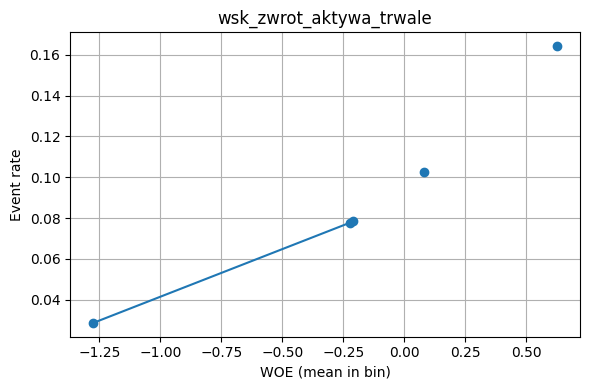

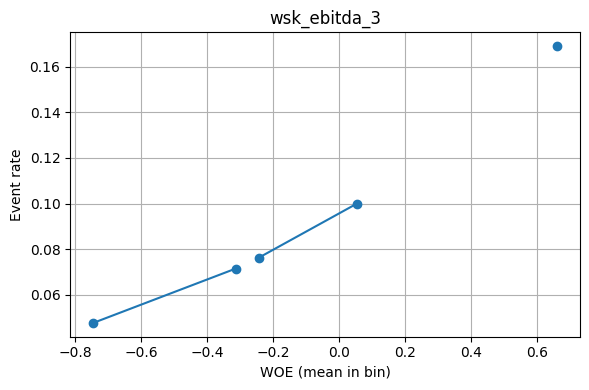

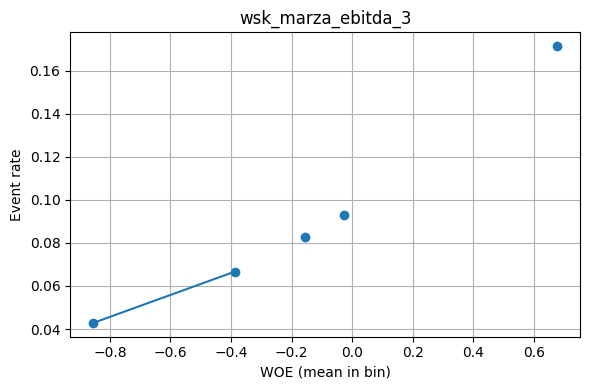

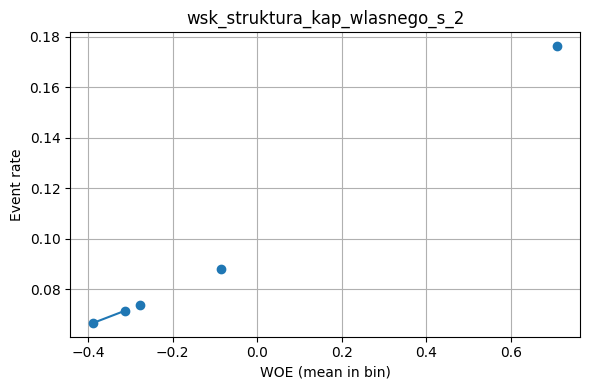

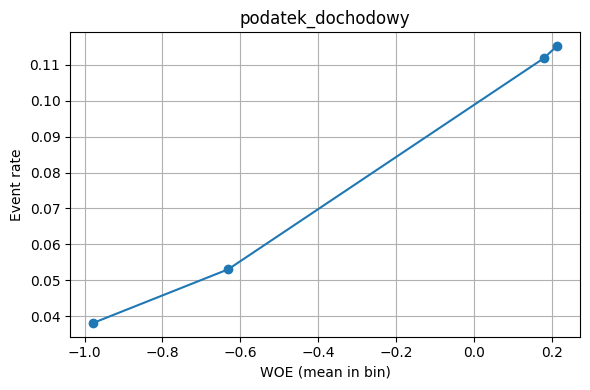

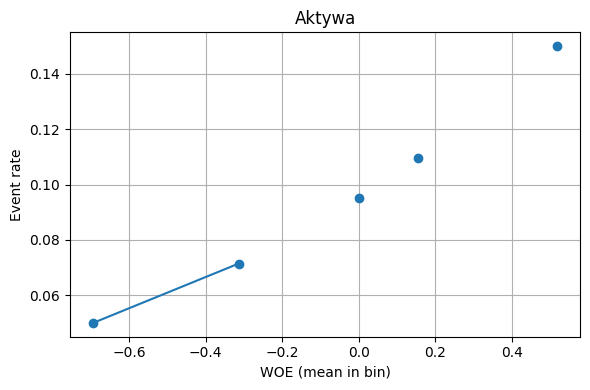

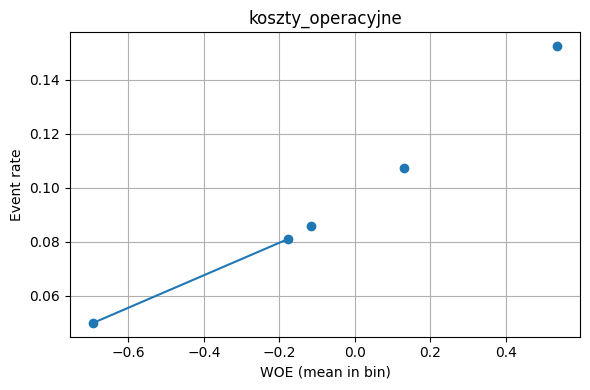

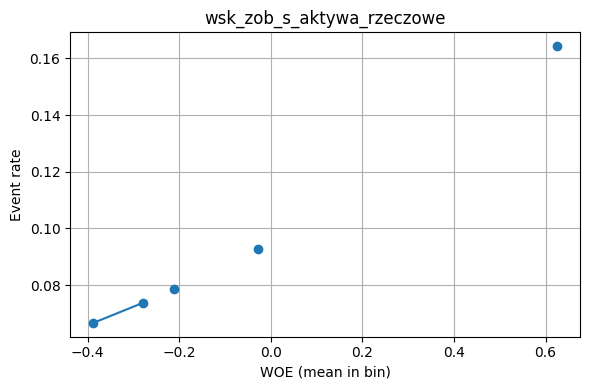

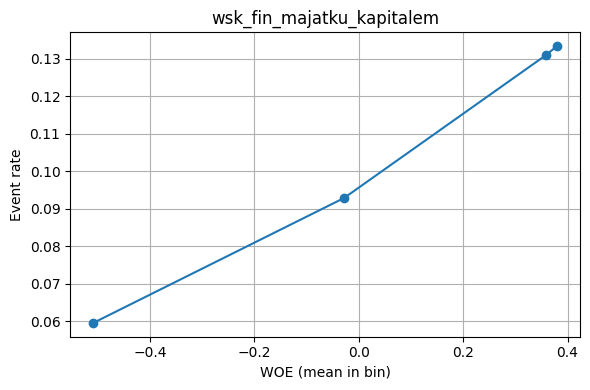

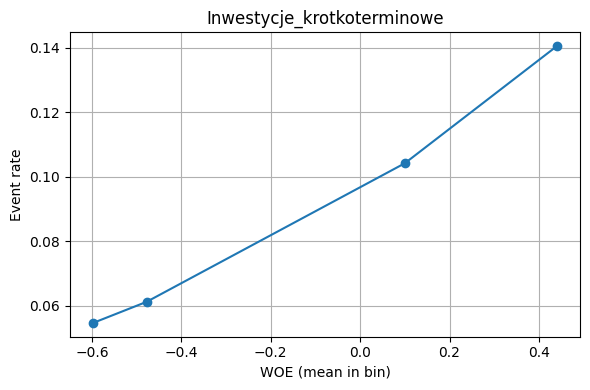

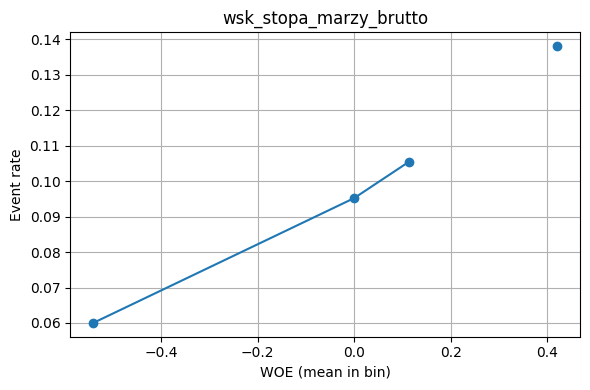

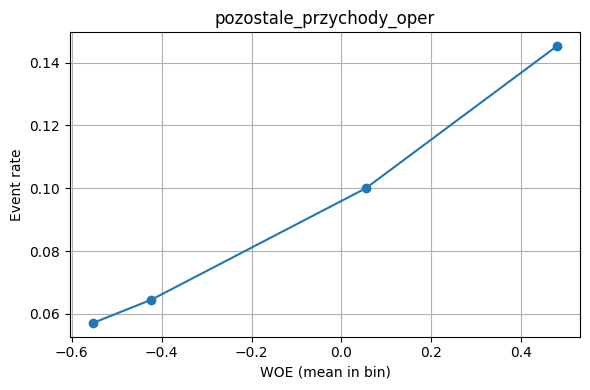

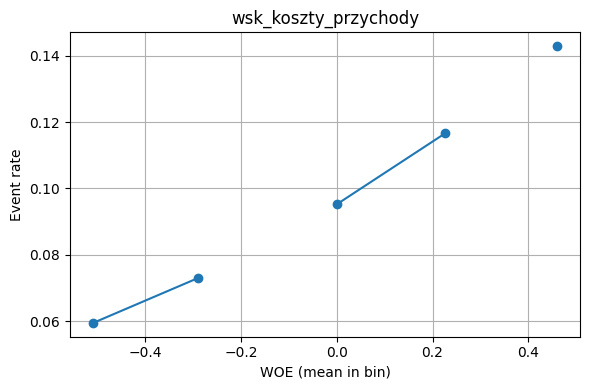

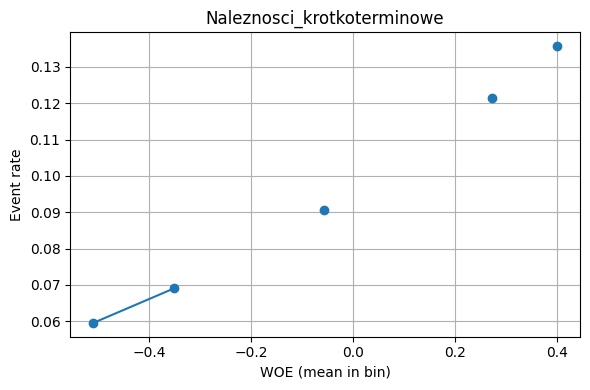

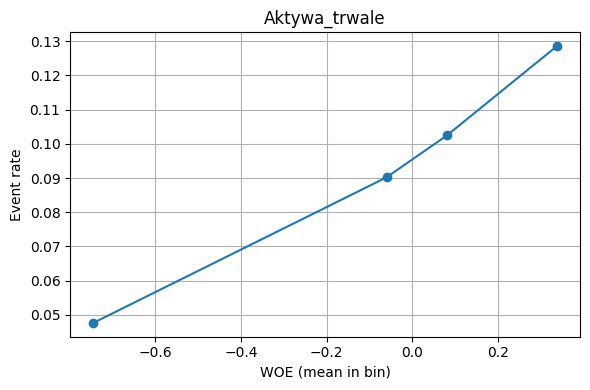

In [10]:
import matplotlib.pyplot as plt
def plot_all_woe_monotonicity(X, y, bins=10):
    
    y_vals = pd.Series(y).reset_index(drop=True)
    for feature in X.columns:
        feat_vals = X[feature].reset_index(drop=True)
        df = pd.DataFrame({feature: feat_vals, "_y": y_vals}).dropna()

        if df[feature].nunique() > 4:
            try:
                binned = pd.qcut(df[feature], q=bins, duplicates='drop')
            except ValueError:
                continue
        else:
            binned = df[feature]

        grouped_rate = df.groupby(binned)["_y"].mean()
        mean_woe = df.groupby(binned)[feature].mean()

        plt.figure(figsize=(6,4))
        plt.plot(mean_woe, grouped_rate, marker='o')
        plt.title(feature)
        plt.xlabel('WOE (mean in bin)')
        plt.ylabel('Event rate')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_all_woe_monotonicity(X_train_t, y_train)

In [11]:
df = X_train_t.copy()
df["_y"] = y_train.values if hasattr(y_train, "values") else y_train

unique_y_per_group = df.groupby(list(X_train_t.columns))["_y"].transform("nunique")

df_consistent = df[unique_y_per_group == 1]

df_final = df_consistent.drop_duplicates(subset=X_train_t.columns, keep="first").reset_index(drop=True)

X_train_t = df_final.drop(columns="_y")
y_train_t = df_final["_y"]
y_val_t = y_val
y_test_t = y_test

print("Początkowa liczba wierszy:", len(df))
print("Liczba po czyszczeniu:", len(df_final))
print("Usunięto wierszy:", len(df) - len(df_final))

Początkowa liczba wierszy: 2100
Liczba po czyszczeniu: 1941
Usunięto wierszy: 159


In [12]:
EPS = 1e-10

def analyze_woe_bins(X_woe, y,
                     min_bin_size=30,
                     woe_threshold=3.0,
                     iv_share_thresh=0.25,
                     spearman_thresh=0.8,
                     order_by='woe'):
    y = pd.Series(y).reset_index(drop=True)
    total_events = y.sum()
    total_non_events = (1 - y).sum()

    profiles = {}
    summary_rows = []

    for feature in X_woe.columns:
        ser = X_woe[feature].reset_index(drop=True)
        df = pd.DataFrame({feature: ser, '_y': y}).dropna()

        grp = df.groupby(feature)['_y'].agg(n='count', events='sum').reset_index().rename(columns={feature:'woe_value'})
        if grp.shape[0] == 0:
            continue

        grp['non_events'] = grp['n'] - grp['events']
        grp['event_rate'] = grp['events'] / grp['n']
        grp['event_dist'] = grp['events'] / (total_events)
        grp['non_event_dist'] = grp['non_events'] / (total_non_events)
        grp['prop_of_population'] = grp['n'] / (grp['n'].sum() + EPS)
        grp['woe'] = grp['woe_value'].astype(float)
        grp['iv_contrib'] = (grp['non_event_dist'] - grp['event_dist']) * grp['woe']

        if order_by == 'woe':
            grp = grp.sort_values('woe').reset_index(drop=True)
        elif order_by == 'event_rate':
            grp = grp.sort_values('event_rate').reset_index(drop=True)
        else:
            grp = grp.reset_index(drop=True)

        grp['cum_event_dist'] = grp['event_dist'].cumsum()
        grp['cum_non_event_dist'] = grp['non_event_dist'].cumsum()
        grp['ks'] = (grp['cum_non_event_dist'] - grp['cum_event_dist']).abs()
        grp['cum_iv'] = grp['iv_contrib'].cumsum()

        total_iv = grp['iv_contrib'].sum()

        try:
            spearman = spearmanr(grp['woe'], np.arange(len(grp)))[0]
        except Exception:
            spearman = np.nan

        grp['flag_small_bin'] = grp['n'] < min_bin_size
        grp['flag_zero_events'] = grp['events'] == 0
        grp['flag_zero_non_events'] = grp['non_events'] == 0
        grp['flag_extreme_woe'] = grp['woe'].abs() > woe_threshold
        grp['iv_share'] = 0.0 if abs(total_iv) < EPS else grp['iv_contrib'] / total_iv
        grp['flag_big_iv_share'] = grp['iv_share'].abs() > iv_share_thresh

        profiles[feature] = grp

        n_bins = grp.shape[0]
        n_small = int(grp['flag_small_bin'].sum())
        n_zero_events = int(grp['flag_zero_events'].sum())
        n_zero_non = int(grp['flag_zero_non_events'].sum())
        n_extreme = int(grp['flag_extreme_woe'].sum())
        n_big_iv = int(grp['flag_big_iv_share'].sum())
        max_ks = float(grp['ks'].max())
        max_iv_share = float(grp['iv_share'].abs().max())
        non_monotonic_flag = (abs(spearman) < spearman_thresh) if not np.isnan(spearman) else True

        summary_rows.append({
            'feature': feature,
            'n_bins': n_bins,
            'total_iv': total_iv,
            'spearman': spearman,
            'non_monotonic': non_monotonic_flag,
            'n_small_bins': n_small,
            'n_bins_zero_events': n_zero_events,
            'n_bins_zero_non_events': n_zero_non,
            'n_extreme_woe_bins': n_extreme,
            'n_big_iv_bins': n_big_iv,
            'max_ks': max_ks,
            'max_iv_share': max_iv_share,
            'prop_pop_min': float(grp['prop_of_population'].min()),
            'prop_pop_max': float(grp['prop_of_population'].max())
        })

    summary = pd.DataFrame(summary_rows).sort_values('total_iv', ascending=False).reset_index(drop=True)
    return profiles, summary


In [13]:
profiles, summary = analyze_woe_bins(X_train_t, y_train_t)

In [14]:
summary

feature  n_bins  total_iv  spearman  \
0                          Aktywa_trwale       4 -0.120268       NaN   
1             Naleznosci_krotkoterminowe       5 -0.129308       NaN   
2               pozostale_przychody_oper       4 -0.136023       NaN   
3                   wsk_koszty_przychody       5 -0.137759       NaN   
4                 wsk_stopa_marzy_brutto       5 -0.138633       NaN   
5             Inwestycje_krotkoterminowe       4 -0.144169       NaN   
6              wsk_zob_s_aktywa_rzeczowe       5 -0.155697       NaN   
7              wsk_fin_majatku_kapitalem       4 -0.157158       NaN   
8                      koszty_operacyjne       5 -0.164505       NaN   
9                                 Aktywa       5 -0.170684       NaN   
10                     podatek_dochodowy       4 -0.193731       NaN   
11        wsk_struktura_kap_wlasnego_s_2       5 -0.203462       NaN   
12                    wsk_marza_ebitda_3       5 -0.219195       NaN   
13                          wsk_ebitda_3       5 -0.232083       NaN   
14               wsk_zwrot_aktywa_trwale       5 -0.238411       NaN   
15       wsk_pokrycie_zob_kr_gotowkowe_1       5 -0.239897       NaN   
16      wsk_pokrycie_wyd_fin_gotowkowe_1       5 -0.248251       NaN   
17               wsk_ebitda_zobowiazan_3       5 -0.250723       NaN   
18  wsk_poziom_kapitalu_obrotowego_netto       5 -0.277559       NaN   
19                wsk_struktury_kapitalu       5 -0.283142       NaN   
20                            Zysk_netto       4 -0.303284       NaN   

    non_monotonic  n_small_bins  n_bins_zero_events  n_bins_zero_non_events  \
0            True             0                   0                       0   
1            True             0                   0                       0   
2            True             0                   0                       0   
3            True             0                   0                       0   
4            True             0                   0                       0   
5            True             0                   0                       0   
6            True             0                   0                       0   
7            True             0                   0                       0   
8            True             0                   0                       0   
9            True             0                   0                       0   
10           True             0                   0                       0   
11           True             0                   0                       0   
12           True             0                   0                       0   
13           True             0                   0                       0   
14           True             0                   0                       0   
15           True             0                   0                       0   
16           True             0                   0                       0   
17           True             0                   0                       0   
18           True             0                   0                       0   
19           True             0                   0                       0   
20           True             0                   0                       0   

    n_extreme_woe_bins  n_big_iv_bins    max_ks  max_iv_share  prop_pop_min  \
0                    0              2  0.122820      0.721336      0.131376   
1                    0              2  0.169334      0.365760      0.149408   
2                    0              2  0.147504      0.445332      0.159196   
3                    0              2  0.177493      0.389325      0.108192   
4                    0              2  0.135185      0.647483      0.108192   
5                    0              2  0.160139      0.407722      0.159711   
6                    0              1  0.172495      0.692001      0.164348   
7                    0              1  0.188124      0.555133      0.157135  

In [19]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 10)

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    # Stała lista solverów (BRAK dynamicznych!)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])

    # Penalizacja zgodna z solverem — jeśli nielegalne: prune trial
    if penalty == "l1" and solver not in ("liblinear", "saga"):
        raise optuna.TrialPruned()

    if penalty == "l2" and solver not in ("liblinear", "lbfgs", "saga"):
        raise optuna.TrialPruned()

    # dual tylko dla l2 + liblinear
    dual = False
    if penalty == 'l2' and solver == 'liblinear':
        dual = trial.suggest_categorical('dual', [True, False])

    max_iter = trial.suggest_int('max_iter', 200, 2000)
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    warm_start = trial.suggest_categorical('warm_start', [False, True])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        dual=dual if (penalty=='l2' and solver=='liblinear') else False,
        class_weight=class_weight,
        max_iter=max_iter,
        tol=tol,
        fit_intercept=fit_intercept,
        warm_start=warm_start,
        random_state=1,
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_t, y_train_t, cv=cv, scoring='roc_auc')

    return scores.mean()


# -------------------------
# Tworzymy i optymalizujemy study
# -------------------------
dataset_name = "example_dataset"
metric = "ROC AUC"
all_results = []

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# -------------------------
# Historia prób w DataFrame
# -------------------------
df_study = study.trials_dataframe(attrs=("number", "value", "params", "state", "duration"))
df_study["dataset"] = dataset_name
df_study["metric"] = metric
all_results.append(df_study)

# -------------------------
# Informacje o najlepszym trialu
# -------------------------
print(f"\n=== {dataset_name.upper()} ===")
print(f"Best {metric}: {study.best_value:.4f}")
print(f"Best params: {study.best_params}\n")

# -------------------------
# Wizualizacje interaktywne w notebooku
# -------------------------
fig1 = vis.plot_optimization_history(study)
fig2 = vis.plot_parallel_coordinate(study)
fig3 = vis.plot_contour(study)
fig3.update_layout(width=1100, height=700)

display(fig1)
display(fig2)
display(fig3)



[I 2025-11-19 18:42:24,828] A new study created in memory with name: no-name-27ac15b4-80c7-4b99-8435-6e31226c62cf


[I 2025-11-19 18:42:24,963] Trial 0 finished with value: 0.7074970293720293 and parameters: {'C': 3.3826286006308384, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 940, 'tol': 7.417997423576191e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'warm_start': False}. Best is trial 0 with value: 0.7074970293720293.
[I 2025-11-19 18:42:24,997] Trial 1 finished with value: 0.7223118551243551 and parameters: {'C': 0.60437117002157, 'penalty': 'l2', 'solver': 'liblinear', 'dual': False, 'max_iter': 1742, 'tol': 0.0018379220005764689, 'class_weight': None, 'fit_intercept': False, 'warm_start': True}. Best is trial 1 with value: 0.7223118551243551.
[I 2025-11-19 18:42:25,094] Trial 2 finished with value: 0.7113227519477521 and parameters: {'C': 0.3760604039899016, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 1584, 'tol': 0.001563389244736595, 'class_weight': 'balanced', 'fit_intercept': True, 'warm_start': True}. Best is trial 1 with value: 0.7223118551243551.
[I 2025-11-19 18:42:25,09


=== EXAMPLE_DATASET ===
Best ROC AUC: 0.7342
Best params: {'C': 0.035744386454005024, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1299, 'tol': 0.007302895622976629, 'class_weight': None, 'fit_intercept': False, 'warm_start': True}



In [20]:
# ---------------------------------------------------------
# 3️⃣ Predykcje
# ---------------------------------------------------------
best_params = study.best_params
print('best params', best_params)
best_model = LogisticRegression(
    **best_params,
    random_state=1
)

best_model.fit(X_train_t, y_train_t)
y_proba_train = best_model.predict_proba(X_train_t)[:, 1]
y_proba_val = best_model.predict_proba(X_val_t)[:, 1]
y_proba_test = best_model.predict_proba(X_test_t)[:, 1]

best params {'C': 0.035744386454005024, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1299, 'tol': 0.007302895622976629, 'class_weight': None, 'fit_intercept': False, 'warm_start': True}


In [21]:
# ---------------------------------------------------------
# 4️⃣ Funkcja do liczenia nowych metryk
# ---------------------------------------------------------

import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, log_loss, roc_curve

def ks_stat_manual(y_true, y_proba):
    """
    KS statistic (ręczna wersja z dystrybuantami)
    """
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)
    
    pos = y_proba[y_true == 1]
    neg = y_proba[y_true == 0]
    
    all_scores = np.sort(np.concatenate([pos, neg]))
    pos_cdf = np.searchsorted(np.sort(pos), all_scores, side='right') / len(pos)
    neg_cdf = np.searchsorted(np.sort(neg), all_scores, side='right') / len(neg)
    
    ks_value = np.max(np.abs(pos_cdf - neg_cdf))
    return ks_value

def ks_stat_roc(y_true, y_proba):
    """
    KS statistic używając roc_curve (szybsza i czytelniejsza)
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return np.max(np.abs(tpr - fpr))

def compute_metrics(y_true, y_proba, use_roc_for_ks=True):
    """
    Compute common classification metrics: ROC AUC, PR AUC, KS statistic, Log-loss.
    
    Parameters:
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels (0 or 1)
    y_proba : array-like of shape (n_samples,)
        Predicted probabilities for the positive class
    use_roc_for_ks : bool
        If True, use roc_curve to compute KS (faster and standard). 
        If False, use manual dystrybuanta method.
    
    Returns:
    -------
    dict
        Dictionary with keys: 'ROC AUC', 'PR AUC', 'KS', 'Log-loss'
    """
    
    # ROC AUC
    roc_auc = roc_auc_score(y_true, y_proba)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)

    # KS statistic
    ks = ks_stat_roc(y_true, y_proba) if use_roc_for_ks else ks_stat_manual(y_true, y_proba)

    # Log-loss
    ll = log_loss(y_true, y_proba)

    return {
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "KS": ks,
        "Log-loss": ll
    }

train_metrics = compute_metrics(y_train_t, y_proba_train)
val_metrics = compute_metrics(y_val_t, y_proba_val)
test_metrics = compute_metrics(y_test_t, y_proba_test)

# ---------------------------------------------------------
# 5️⃣ Tabela porównawcza
# ---------------------------------------------------------

results_df = pd.DataFrame([train_metrics, val_metrics, test_metrics], index=["Train", "Validation","Test"]).T

results_df = results_df.round(4)


results_df

Train  Validation    Test
ROC AUC   0.7403      0.7289  0.7218
PR AUC    0.2288      0.1747  0.1929
KS        0.3970      0.3851  0.4148
Log-loss  0.6059      1.1019  1.0253

#### Wyznaczenie VIF dla każdej zmiennej

In [24]:
def calculate_vif_dataframe(df_input):
    X = df_input.copy()
    X = add_constant(X)

    vif_data = pd.DataFrame()
    vif_data["Zmienna"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(len(X.columns))]

    vif_data = vif_data[vif_data["Zmienna"] != "const"]
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
    
    return vif_data

In [25]:
calculate_vif_dataframe(X_train_t)

Zmienna       VIF
0                                 Aktywa  4.737536
1                             Zysk_netto  4.042137
2                     wsk_marza_ebitda_3  4.030652
3         wsk_struktura_kap_wlasnego_s_2  3.608593
4        wsk_pokrycie_zob_kr_gotowkowe_1  3.576409
5                           wsk_ebitda_3  3.330890
6                wsk_ebitda_zobowiazan_3  3.252842
7                 wsk_struktury_kapitalu  3.018086
8       wsk_pokrycie_wyd_fin_gotowkowe_1  2.907111
9                 wsk_stopa_marzy_brutto  2.724895
10  wsk_poziom_kapitalu_obrotowego_netto  2.698356
11             wsk_zob_s_aktywa_rzeczowe  2.611735
12                  wsk_koszty_przychody  2.581949
13                     podatek_dochodowy  2.452335
14                         Aktywa_trwale  2.294943
15                     koszty_operacyjne  2.199767
16            Inwestycje_krotkoterminowe  2.032293
17             wsk_fin_majatku_kapitalem  1.895995
18               wsk_zwrot_aktywa_trwale  1.875307
19            Naleznosci_krotkoterminowe  1.848120
20              pozostale_przychody_oper  1.522583

##### Wszystkie zmienne mają akceptowalne VIF (poniżej 5). Nie ma zmiennej specjalnie zależnej od innych.

### Testy monotoniczności kierunków wpływu

In [39]:
def get_model_statistics(model, X_train, feature_names):
    coefs = model.coef_[0]
    intercept = model.intercept_[0]

    params = np.r_[intercept, coefs]

    n = len(X_train)
    X_design = np.hstack([np.ones((n, 1)), X_train])

    probs = model.predict_proba(X_train)[:, 1]

    W = probs * (1 - probs)

    Hessian = np.dot(X_design.T, W[:, None] * X_design)

    cov_matrix = np.linalg.inv(Hessian)

    std_errors = np.sqrt(np.diag(cov_matrix))

    z_scores = params / std_errors

    p_values = stats.norm.sf(np.abs(z_scores)) * 2

    ci_lower = params - 1.96 * std_errors
    ci_upper = params + 1.96 * std_errors

    all_names = ['Intercept'] + list(feature_names)
    
    summary_df = pd.DataFrame({
        'Zmienna': all_names,
        'Współczynnik (Beta)': params,
        'Odds Ratio': np.exp(params),
        'P-value': p_values.round(4),
        'CI Dolny (2.5%)': ci_lower,
        'CI Górny (97.5%)': ci_upper
    })
    summary_df = summary_df.sort_values(by='Współczynnik (Beta)', ascending=False).reset_index(drop=True)
    
    return summary_df

In [40]:
final_stats = get_model_statistics(best_model, X_train_t, X_train_t.columns)
final_stats

Zmienna  Współczynnik (Beta)  Odds Ratio  \
0                 wsk_struktury_kapitalu             0.356187    1.427875   
1   wsk_poziom_kapitalu_obrotowego_netto             0.344384    1.411120   
2                                 Aktywa             0.270108    1.310106   
3         wsk_struktura_kap_wlasnego_s_2             0.213781    1.238351   
4                          Aktywa_trwale             0.205340    1.227942   
5              wsk_zob_s_aktywa_rzeczowe             0.202241    1.224142   
6              wsk_fin_majatku_kapitalem             0.197428    1.218265   
7               pozostale_przychody_oper             0.175554    1.191906   
8       wsk_pokrycie_wyd_fin_gotowkowe_1             0.155691    1.168465   
9                wsk_zwrot_aktywa_trwale             0.138737    1.148822   
10               wsk_ebitda_zobowiazan_3             0.117341    1.124503   
11                            Zysk_netto             0.117134    1.124270   
12       wsk_pokrycie_zob_kr_gotowkowe_1             0.110503    1.116839   
13            Inwestycje_krotkoterminowe             0.101819    1.107183   
14                          wsk_ebitda_3             0.088901    1.092972   
15                     podatek_dochodowy             0.085902    1.089699   
16            Naleznosci_krotkoterminowe             0.085335    1.089082   
17                     koszty_operacyjne             0.058061    1.059779   
18                    wsk_marza_ebitda_3             0.029685    1.030130   
19                wsk_stopa_marzy_brutto             0.024568    1.024872   
20                             Intercept             0.000000    1.000000   
21                  wsk_koszty_przychody            -0.027967    0.972421   

    P-value  CI Dolny (2.5%)  CI Górny (97.5%)  
0    0.0357         0.023807          0.688567  
1    0.0144         0.068513          0.620255  
2    0.3019        -0.242665          0.782881  
3    0.3347        -0.220581          0.648142  
4    0.3050        -0.186978          0.597658  
5    0.3363        -0.210055          0.614536  
6    0.2369        -0.129755          0.524611  
7    0.2720        -0.137714          0.488822  
8    0.3649        -0.181122          0.492504  
9    0.2919        -0.119281          0.396755  
10   0.4875        -0.213935          0.448617  
11   0.4809        -0.208548          0.442816  
12   0.5453        -0.247599          0.468604  
13   0.5652        -0.245179          0.448817  
14   0.6276        -0.270272          0.448073  
15   0.5792        -0.217707          0.389511  
16   0.6393        -0.271539          0.442209  
17   0.7374        -0.281289          0.397411  
18   0.8916        -0.397375          0.456746  
19   0.9027        -0.369446          0.418581  
20   1.0000        -0.100089          0.100089  
21   0.8946        -0.441816          0.385882

### Mamy dużo wysokich p-wartości. Usuńmy zmienne aż wszystkie w modelu będą adekwatne.

In [43]:
class WaldSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.selected_features_ = []
        self.model_summary_ = None 
        
    def fit(self, X, y):
        features = list(X.columns)
        
        while len(features) > 0:
            X_current = X[features].copy()
            X_const = sm.add_constant(X_current)
            model = sm.Logit(y, X_const).fit(disp=0)
            p_values = model.pvalues

            if 'const' in p_values:
                p_values = p_values.drop('const')

            max_p_value = p_values.max()
            worst_feature = p_values.idxmax()

            if max_p_value > self.threshold:
                features.remove(worst_feature)
            else:
                self.model_summary_ = model.summary() 
                break

        self.selected_features_ = features
        return self

    def transform(self, X):
        return X[self.selected_features_]

In [ ]:
selector = WaldSelector(threshold=0.05)
selector.fit(X_train_t, y_train_t)
X_train_final = selector.transform(X_train_t)
X_val_final = selector.transform(X_val_t)
X_test_final = selector.transform(X_test_t)


In [53]:
y_train_final = y_train_t
y_val_final = y_val_t
y_test_final = y_test_t

In [52]:
X_train_final

wsk_struktury_kapitalu  wsk_poziom_kapitalu_obrotowego_netto  \
0                  -0.178185                              0.131028   
1                  -0.178185                             -0.977534   
2                  -0.178185                              0.379490   
3                  -0.178185                              0.379490   
4                  -0.243978                              0.131028   
...                      ...                                   ...   
1936                0.773190                              0.379490   
1937                0.773190                             -0.977534   
1938                0.773190                              0.439951   
1939                0.773190                             -0.977534   
1940               -0.115832                              0.131028   

      wsk_zwrot_aktywa_trwale  koszty_operacyjne  Aktywa_trwale  
0                    0.080247           0.131028       0.081406  
1                   -0.210625          -0.115832      -0.744440  
2                    0.624612          -0.178185       0.081406  
3                   -0.221639          -0.178185       0.081406  
4                   -0.210625           0.535244       0.081406  
...                       ...                ...            ...  
1936                 0.624612           0.131028       0.337643  
1937                 0.080247          -0.693147       0.081406  
1938                -0.210625           0.131028       0.081406  
1939                 0.080247          -0.115832      -0.744440  
1940                 0.080247           0.131028       0.081406  

[1941 rows x 5 columns]

### Interpretacja globalna

RANKING WAŻNOŚCI CECH:
                             Zmienna  Beta (Współczynnik)  Ważność %
              wsk_struktury_kapitalu                 1.02      29.47
             wsk_zwrot_aktywa_trwale                 0.71      20.57
                       Aktywa_trwale                 0.66      18.96
wsk_poziom_kapitalu_obrotowego_netto                 0.60      17.37
                   koszty_operacyjne                 0.47      13.62


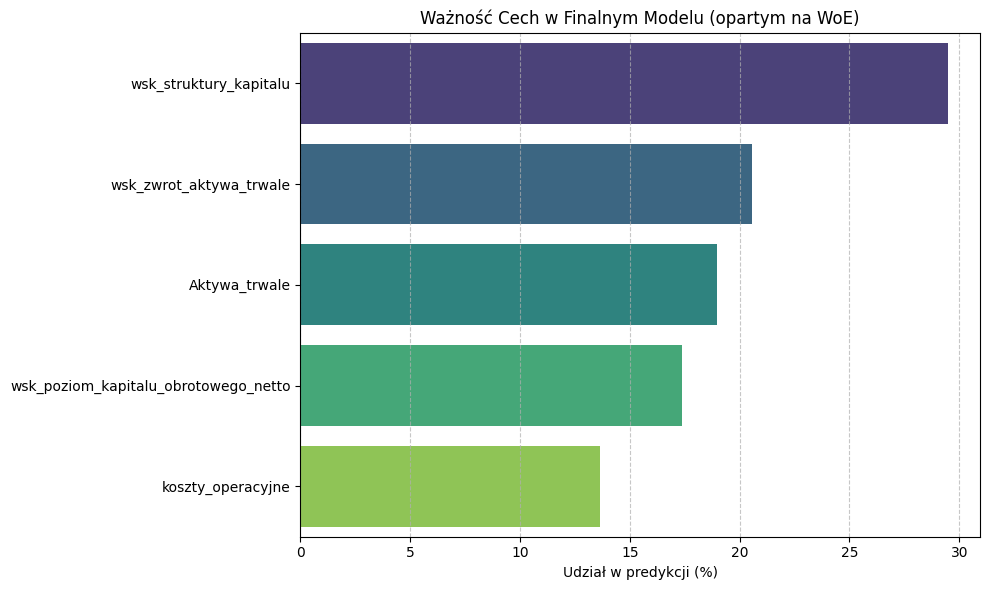

In [55]:
final_model = LogisticRegression(fit_intercept=True, solver='newton-cg')
final_model.fit(X_train_final, y_train_final)

feature_names = X_train_final.columns
coefficients = final_model.coef_[0]

importance_df = pd.DataFrame({
    'Zmienna': feature_names,
    'Beta (Współczynnik)': coefficients,
    'Wpływ (Abs Beta)': np.abs(coefficients) 
})

total_importance = importance_df['Wpływ (Abs Beta)'].sum()
importance_df['Ważność %'] = (importance_df['Wpływ (Abs Beta)'] / total_importance) * 100

importance_df = importance_df.sort_values(by='Ważność %', ascending=False)

print("RANKING WAŻNOŚCI CECH:")
print(importance_df[['Zmienna', 'Beta (Współczynnik)', 'Ważność %']].to_string(index=False, float_format="%.2f"))

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Ważność %', y='Zmienna', palette='viridis')
plt.title('Ważność Cech w Finalnym Modelu (opartym na WoE)')
plt.xlabel('Udział w predykcji (%)')
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
def calculate_model_metrics(model, X_val, y_val):
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_pred_proba)

    pr_auc = average_precision_score(y_val, y_pred_proba)

    probs_class_1 = y_pred_proba[y_val == 1]
    probs_class_0 = y_pred_proba[y_val == 0]

    ks_statistic, p_value = ks_2samp(probs_class_1, probs_class_0)
  
    ll = log_loss(y_val, y_pred_proba)

    brier = brier_score_loss(y_val, y_pred_proba)

    metrics_df = pd.DataFrame({
        'Metryka': ['AUC ROC', 'PR-AUC', 'KS Statistic', 'Log-loss', 'Brier Score'],
        'Wartość': [roc_auc, pr_auc, ks_statistic, ll, brier]
    })
    
    return metrics_df, y_pred_proba

metrics_table, probs = calculate_model_metrics(final_model, X_val_final, y_val)

print("WYNIKI MODELU NA ZBIORZE WALIDACYJNYM:")
print(metrics_table.to_string(index=False, float_format="%.4f"))

WYNIKI MODELU NA ZBIORZE WALIDACYJNYM:
     Metryka  Wartość
     AUC ROC   0.7368
      PR-AUC   0.2418
KS Statistic   0.3600
    Log-loss   0.2803
 Brier Score   0.0795


### Wykresy PDP/ICE 

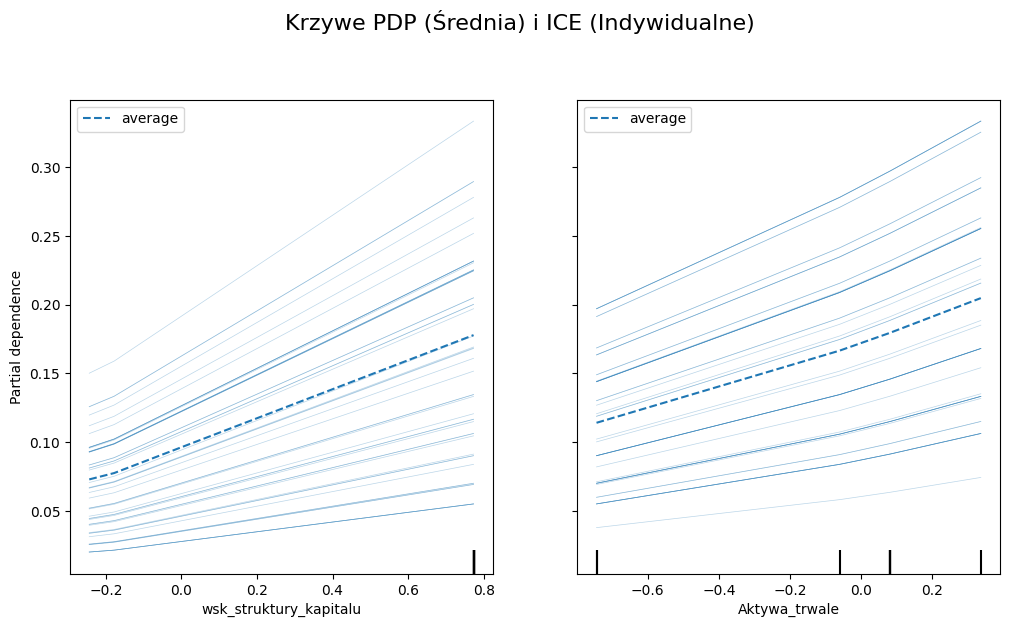

In [64]:
features_to_plot = ['wsk_struktury_kapitalu', 'Aktywa_trwale'] 

fig, ax = plt.subplots(figsize=(12, 6))

display = PartialDependenceDisplay.from_estimator(
    estimator=final_model,      
    X=X_val_final,            
    features=features_to_plot,  
    kind='both',              
    subsample=50,             
    n_jobs=-1,                 
    grid_resolution=20,      
    ax=ax
)

plt.suptitle('Krzywe PDP (Średnia) i ICE (Indywidualne)', fontsize=16, y=1.05)
plt.subplots_adjust(top=0.9) 
plt.show()